# Experiment 5: Text Generation using RNN

**Objective:** Explore text generation using RNNs and compare:
1. One-Hot Encoding
2. Trainable Word Embeddings

Dataset: 100 poems (`poems100.csv`)

## 1. Setup and Data Loading

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
import re

np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv("poems100.csv", quoting=1)
text = " ".join(df["text"].astype(str).tolist())

# Tokenize: split on non-alphanumeric, keep words
words = re.findall(r"\b[a-zA-Z']+\b", text.lower())
print(f"Total words: {len(words)}")
print(f"Sample: {words[:20]}")

Total words: 25141
Sample: ['o', 'my', "luve's", 'like', 'a', 'red', 'red', 'rose', 'that', 's', 'newly', 'sprung', 'in', 'june', 'o', 'my', "luve's", 'like', 'the', 'melodie']


In [2]:
# Fixed sequence length for "input sequence -> next word" prediction
SEQ_LEN = 8
# Build vocabulary: keep top 2000 words by frequency, rest -> <UNK>
from collections import Counter
word_counts = Counter(words)
vocab_size_cap = 2000
vocab_list = ["<UNK>"] + [w for w, _ in word_counts.most_common(vocab_size_cap - 1)]
word2idx = {w: i for i, w in enumerate(vocab_list)}
idx2word = {i: w for i, w in enumerate(vocab_list)}
vocab_size = len(vocab_list)
print(f"Vocabulary size: {vocab_size}")
# Convert to indices (words not in vocab -> 0 for <UNK>)
indices = [word2idx.get(w, 0) for w in words]

Vocabulary size: 2000


## 2. Part 1: RNN From Scratch (NumPy)

Forward pass only. Equations:
- $h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$
- $y_t = W_{hy} h_t + b_y$ (logits)

In [3]:
input_size = 4
hidden_size = 8
output_size = 4
scale = 0.01

W_xh = np.random.randn(input_size, hidden_size) * scale
W_hh = np.random.randn(hidden_size, hidden_size) * scale
b_h = np.zeros(hidden_size)
W_hy = np.random.randn(hidden_size, output_size) * scale
b_y = np.zeros(output_size)

def rnn_step(x_t, h_prev, W_xh, W_hh, b_h, W_hy, b_y):
    h_t = np.tanh(np.dot(x_t, W_xh) + np.dot(h_prev, W_hh) + b_h)
    y_t = np.dot(h_t, W_hy) + b_y
    return h_t, y_t

# Tiny sequence of one-hot vectors (5 timesteps)
T = 5
h = np.zeros(hidden_size)
for t in range(T):
    x_t = np.zeros(input_size)
    x_t[t % input_size] = 1.0
    h, y = rnn_step(x_t, h, W_xh, W_hh, b_h, W_hy, b_y)
    print(f"t={t} h[:3]={h[:3].round(4)} y={y.round(4)}")
print("NumPy RNN forward pass completed.")

t=0 h[:3]=[ 0.005  -0.0014  0.0065] y=[ 0.0002  0.     -0.     -0.0003]
t=1 h[:3]=[-0.0049  0.0052 -0.0042] y=[-0.0003  0.0003 -0.0004  0.0001]
t=2 h[:3]=[-0.01    0.0029 -0.0089] y=[-0.0002  0.      0.0002  0.0001]
t=3 h[:3]=[-0.0051  0.0015 -0.0116] y=[ 0.0001  0.0003 -0.0006 -0.0001]
t=4 h[:3]=[ 0.0048 -0.0012  0.0064] y=[ 0.0002  0.     -0.     -0.0003]
NumPy RNN forward pass completed.


## 3. Part 2: One-Hot Encoding Approach

Tokenize -> one-hot vectors -> RNN -> predict next word.

In [4]:
# Build (sequence, next_word) pairs from indices
def build_sequences(indices, seq_len):
    X, y = [], []
    for i in range(len(indices) - seq_len):
        X.append(indices[i : i + seq_len])
        y.append(indices[i + seq_len])
    return np.array(X), np.array(y)

X_seq, y_target = build_sequences(indices, SEQ_LEN)
# One-hot encode X: (N, seq_len) -> (N, seq_len, vocab_size)
def one_hot_encode(seq_batch, vocab_size):
    n = seq_batch.shape[0]
    sl = seq_batch.shape[1]
    onehot = np.zeros((n, sl, vocab_size), dtype=np.float32)
    for i in range(n):
        for j in range(sl):
            onehot[i, j, seq_batch[i, j]] = 1.0
    return onehot

X_onehot = one_hot_encode(X_seq, vocab_size)
print(f"X_onehot shape: {X_onehot.shape}, y_target shape: {y_target.shape}")

X_onehot shape: (25133, 8, 2000), y_target shape: (25133,)


In [5]:
# RNN model: input (batch, seq_len, vocab_size) -> next word logits
class RNN_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, vocab_size)
        out, _ = self.rnn(x)
        # use last timestep to predict next word
        last = out[:, -1, :]
        return self.fc(last)

hidden_size = 128
model_onehot = RNN_OneHot(vocab_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer_onehot = torch.optim.Adam(model_onehot.parameters(), lr=1e-3)

In [6]:
# Training: small batches, record loss and time
BATCH_SIZE = 32
EPOCHS_ONEHOT = 30
losses_onehot = []
start_onehot = time.time()
for epoch in range(EPOCHS_ONEHOT):
    perm = np.random.permutation(len(X_onehot))
    epoch_loss = 0.0
    n_batches = 0
    for i in range(0, len(X_onehot), BATCH_SIZE):
        idx = perm[i : i + BATCH_SIZE]
        x_b = torch.tensor(X_onehot[idx], dtype=torch.float32)
        y_b = torch.tensor(y_target[idx], dtype=torch.long)
        optimizer_onehot.zero_grad()
        logits = model_onehot(x_b)
        loss = criterion(logits, y_b)
        loss.backward()
        optimizer_onehot.step()
        epoch_loss += loss.item()
        n_batches += 1
    avg = epoch_loss / max(n_batches, 1)
    losses_onehot.append(avg)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS_ONEHOT} loss={avg:.4f}")
time_onehot = time.time() - start_onehot
print(f"One-hot training time: {time_onehot:.2f}s")

Epoch 10/30 loss=3.0131
Epoch 20/30 loss=0.9526
Epoch 30/30 loss=0.2345
One-hot training time: 289.00s


In [7]:
def generate_onehot(model, seed_words, num_words, word2idx, idx2word, seq_len):
    model.eval()
    with torch.no_grad():
        words = seed_words.copy()
        for _ in range(num_words):
            seq = [word2idx.get(w.lower(), 0) for w in words[-seq_len:]]
            onehot = np.zeros((1, len(seq), len(word2idx)), dtype=np.float32)
            for j, idx in enumerate(seq):
                onehot[0, j, idx] = 1.0
            x = torch.tensor(onehot, dtype=torch.float32)
            logits = model(x)
            next_idx = logits.argmax(dim=1).item()
            words.append(idx2word[next_idx])
    return " ".join(words)

seed = words[:SEQ_LEN]  # seed length = SEQ_LEN for full input
gen_onehot = generate_onehot(model_onehot, seed, 25, word2idx, idx2word, SEQ_LEN)
print("Generated (one-hot):", gen_onehot)

Generated (one-hot): o my luve's like a red red rose that s newly sprung in june o my luve's like the melodie that s sweetly play'd in tune as fair art thou my bonnie lass


## 4. Part 3: Trainable Word Embeddings Approach

Same vocabulary; words as indices -> Embedding layer -> RNN -> predict next word.

In [8]:
# Reuse X_seq, y_target (index sequences). No one-hot.
# Model: Embedding -> RNN -> Linear
class RNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len) Long
        emb = self.embed(x)
        out, _ = self.rnn(emb)
        last = out[:, -1, :]
        return self.fc(last)

embedding_dim = 64
model_emb = RNN_Embedding(vocab_size, embedding_dim, hidden_size)
optimizer_emb = torch.optim.Adam(model_emb.parameters(), lr=1e-3)

In [9]:
# Training with same epochs, record loss and time
EPOCHS_EMB = 30
losses_emb = []
start_emb = time.time()
for epoch in range(EPOCHS_EMB):
    perm = np.random.permutation(len(X_seq))
    epoch_loss = 0.0
    n_batches = 0
    for i in range(0, len(X_seq), BATCH_SIZE):
        idx = perm[i : i + BATCH_SIZE]
        x_b = torch.tensor(X_seq[idx], dtype=torch.long)
        y_b = torch.tensor(y_target[idx], dtype=torch.long)
        optimizer_emb.zero_grad()
        logits = model_emb(x_b)
        loss = criterion(logits, y_b)
        loss.backward()
        optimizer_emb.step()
        epoch_loss += loss.item()
        n_batches += 1
    avg = epoch_loss / max(n_batches, 1)
    losses_emb.append(avg)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS_EMB} loss={avg:.4f}")
time_emb = time.time() - start_emb
print(f"Embedding training time: {time_emb:.2f}s")

Epoch 10/30 loss=2.9642
Epoch 20/30 loss=1.3879
Epoch 30/30 loss=0.6393
Embedding training time: 230.28s


In [10]:
def generate_embedding(model, seed_words, num_words, word2idx, idx2word, seq_len):
    model.eval()
    with torch.no_grad():
        words = seed_words.copy()
        for _ in range(num_words):
            seq = [word2idx.get(w.lower(), 0) for w in words[-seq_len:]]
            x = torch.tensor([seq], dtype=torch.long)
            logits = model(x)
            next_idx = logits.argmax(dim=1).item()
            words.append(idx2word[next_idx])
    return " ".join(words)

gen_emb = generate_embedding(model_emb, seed, 25, word2idx, idx2word, SEQ_LEN)  # same seed as one-hot
print("Generated (embeddings):", gen_emb)

Generated (embeddings): o my luve's like a red red rose that s newly sprung in june o my luve's like the melodie that s sweetly play'd in tune as fair art thou my bonnie lass


## 5. Comparison and Analysis

In [11]:
# Metrics
print("=== Training time (seconds) ===")
print(f"One-hot:    {time_onehot:.2f}s")
print(f"Embedding:  {time_emb:.2f}s")
print("\n=== Final loss ===")
print(f"One-hot:    {losses_onehot[-1]:.4f}")
print(f"Embedding:  {losses_emb[-1]:.4f}")

=== Training time (seconds) ===
One-hot:    289.00s
Embedding:  230.28s

=== Final loss ===
One-hot:    0.2345
Embedding:  0.6393


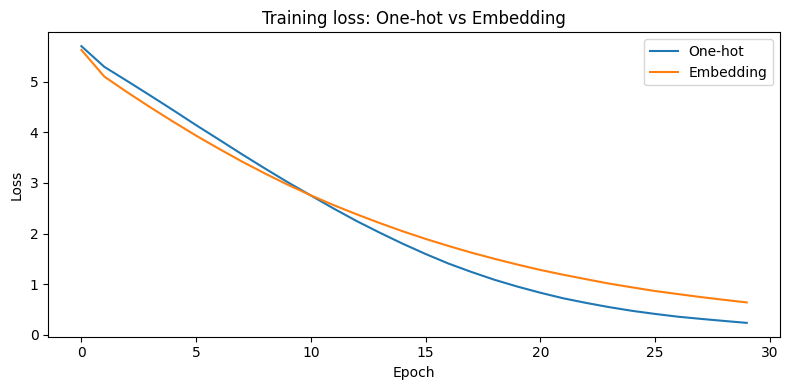

In [12]:
# Loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(losses_onehot, label="One-hot")
plt.plot(losses_emb, label="Embedding")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training loss: One-hot vs Embedding")
plt.tight_layout()
plt.show()

In [13]:
# Qualitative: same seed, both models
print("Seed:", " ".join(seed))
print("\nOne-hot:   ", gen_onehot)
print("\nEmbedding: ", gen_emb)

Seed: o my luve's like a red red rose

One-hot:    o my luve's like a red red rose that s newly sprung in june o my luve's like the melodie that s sweetly play'd in tune as fair art thou my bonnie lass

Embedding:  o my luve's like a red red rose that s newly sprung in june o my luve's like the melodie that s sweetly play'd in tune as fair art thou my bonnie lass


### Discussion

**One-Hot Encoding**
- **Pros:** Simple, no learned input representation.
- **Cons:** Input dimension = vocab_size (large); no notion of similarity between words; first layer has many parameters; typically slower and can yield higher loss.

**Trainable Word Embeddings**
- **Pros:** Smaller input dimension (embedding_dim); model learns semantic similarity; usually faster training and better loss; often better quality of generated text.
- **Cons:** Slightly more complex (extra embedding layer and hyperparameter).